<a href="https://colab.research.google.com/github/AlyssaTang/FutureMakers/blob/main/UPDATED_Cats_and_Dogs_Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats and Dogs Image classification

Kaggle dataset: Cats vs Dogs

# Results of runs:

Initial: val_loss: 0.5059 - val_accuracy: 0.7890

Changed epochs to 5: loss: 0.2373 - accuracy: 0.8991 - val_loss: 0.2533 - val_accuracy: 0.8953

Changed learning rate to 0.0001: was taking hours to run so stopped at 3/5 epochs and the accuracy seems to be increasing (it was at 0.81 partially through the 3rd epoch) but I would predict that it wouldn't be better than the previous run, so I believe 0.001 would have a better option.

In the future I could also try changing the optimizer to SGD, however colab GPU was not available while I was running it (since I don't have Colab Pro) so it would have taken too long to finish.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load the data

In [2]:
# from google.colab import files
# files.upload() #upload kaggle.json

# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json

!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   180M      0  0:00:04  0:00:04 --:--:--  180M


In [6]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

# !unzip -q catsanddogs.zip


 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [7]:
!ls PetImages


Cat  Dog


### Filter out corrupted/badly-encoded images that don't feature the string "JFIF" in their header.


In [9]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

#find file dimensions and size

Deleted 0 images


## Generate a `Dataset`


In [10]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


## Visualize the data

Graphing the first 9 images in the training dataset. Label 1 = "dog" & label 0 = "cat".


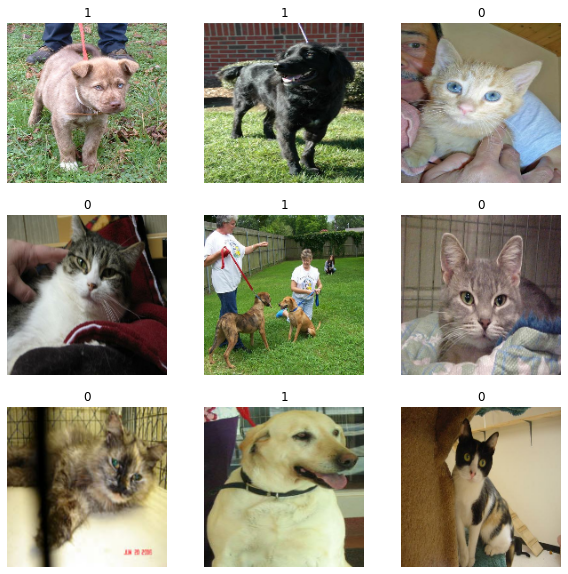

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Image data augmentation


In [12]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


Visualizing what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


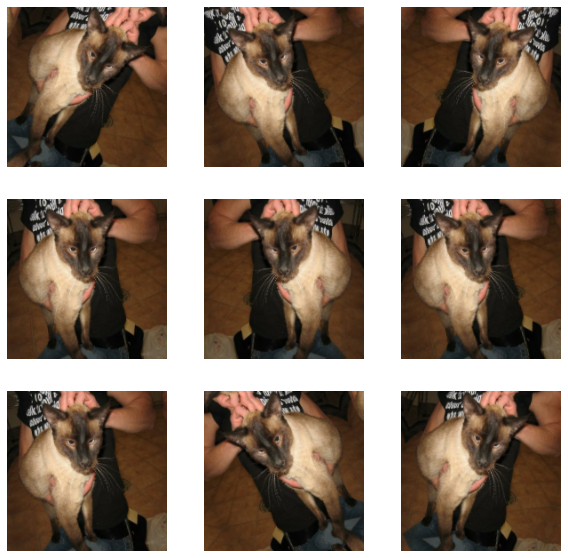

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Standardizing the data

The image are already in a standard size (180x180) since they are contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range so standardizing values to be in the `[0, 1]` is using a `Rescaling` layer at the start of our model is important.


## Configure the dataset for performance

Use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [14]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a model

- Start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- Include a `Dropout` layer before the final classification layer.


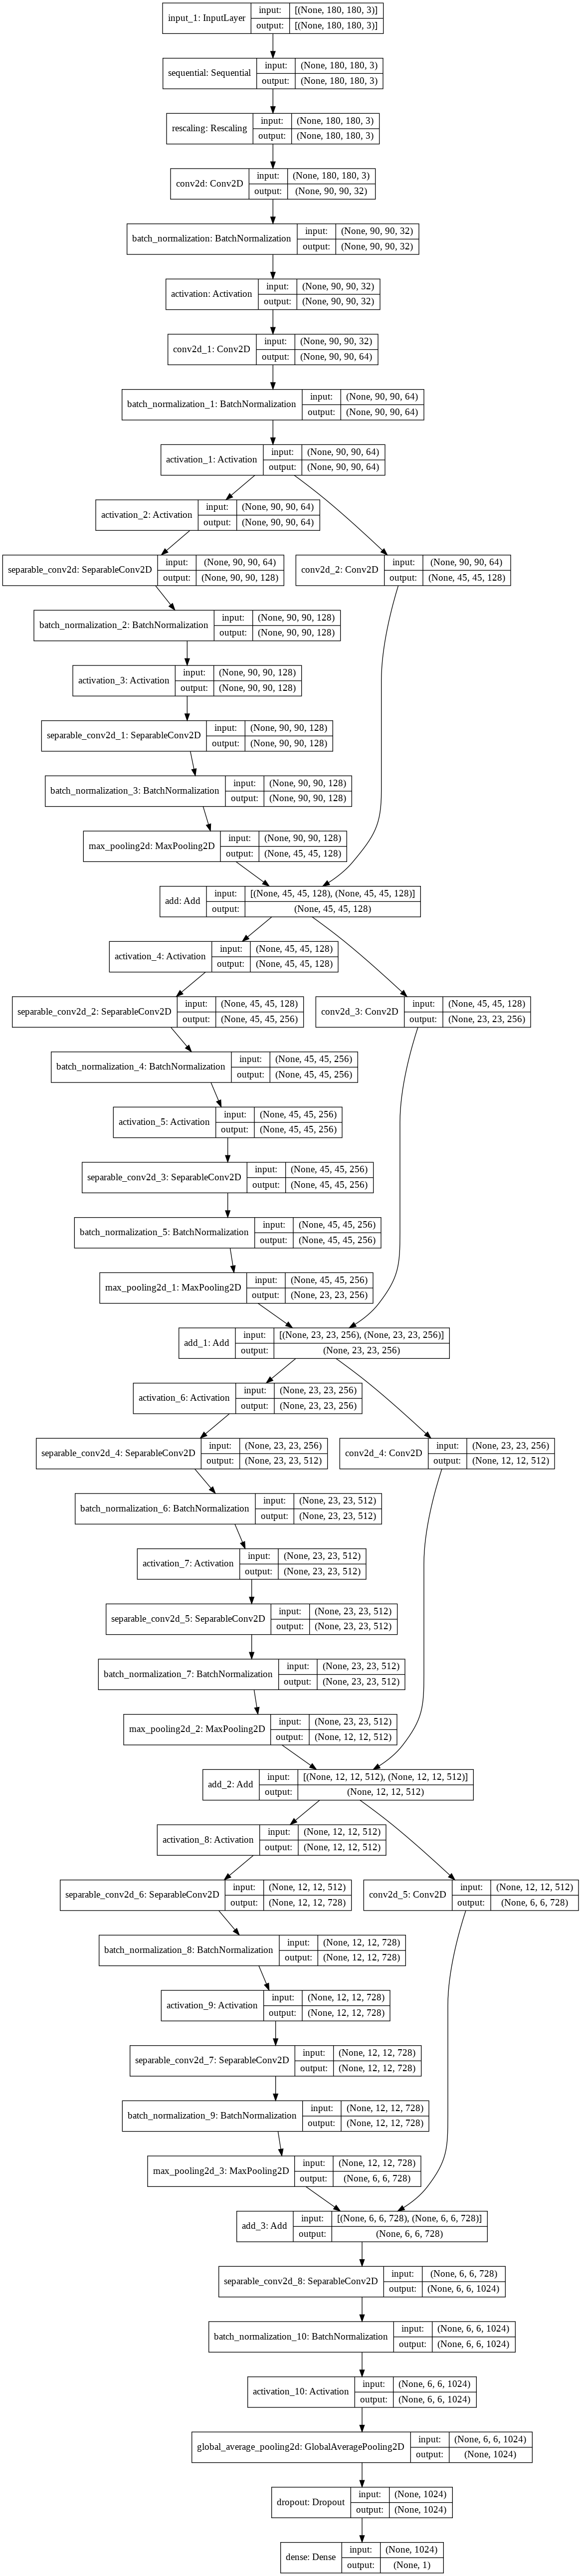

In [15]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


## Train the model


In [ ]:
epochs = 5 #decreased to lessen runtime

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(0.0001), #1e-3, can try 0.0001 later or SGD
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

# Results

Initial: val_loss: 0.5059 - val_accuracy: 0.7890

Changed epochs to 5: loss: 0.2373 - accuracy: 0.8991 - val_loss: 0.2533 - val_accuracy: 0.8953

Changed learning rate to 0.0001: was taking hours to run so stopped at 3/5 epochs and the accuracy seems to be increasing (it was at 0.81 partially through the 3rd epoch) but I would predict that it wouldn't be better than the previous run, so I believe 0.001 would have a better option.

In the future I could also try changing the optimizer to SGD, however colab GPU was not available while I was running it (since I don't have Colab Pro) so it would have taken too long to finish.

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.


In [21]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size # change file directory?
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 89.16 percent cat and 10.84 percent dog.
